## Capstone - Speech Emotion Recognition 

## Dataset

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS),and it is free to download. This dataset has 7356 files rated by 247 individuals 10 times on emotional validity, intensity, and genuineness. here the Speech files of all actors (01-24) will be used and the files are available under path ../datasets/RAVDESS. It contains 1440 files: 60 trials per actor x 24 actors = 1440. 
Filename identifiers:
<ol>
<li>Modality (01 = full-AV, 02 = video-only, 03 = audio-only).</li>
<li>Vocal channel (01 = speech, 02 = song).</li>
<li>Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).</li>
<li>Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.</li>
<li>Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").</li>
<li>Repetition (01 = 1st repetition, 02 = 2nd repetition)..</li>
<li>Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).</li>
</ol>

### Libraries imports

In [ ]:
#pip install librosa soundfile numpy sklearn pyaudio

In [ ]:
#pip install --upgrade tensorflow

In [22]:
# Import libraries 
import librosa
import librosa.display
import soundfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd

import seaborn as sns
import scipy.io

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

import IPython.display as ipd  # To play sound in the notebook
import os, glob, pickle
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Retrieve RAVDESS dataset from File System

In [23]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

TESS = "../datasets/TESS Toronto emotional speech set data/TESS Toronto emotional speech set data/"
RAV = "../datasets/RAVDESS/audio_speech_actors_01-24/"
SAVEE = "../datasets/ALL/"
CREMA = "../datasets/AudioWAV/"

# Run one example 
dir_list = os.listdir(RAV+"Actor_01/")
dir_list[0:5]

['03-01-01-01-01-01-01.wav',
 '03-01-01-01-01-02-01.wav',
 '03-01-01-01-02-01-01.wav',
 '03-01-01-01-02-02-01.wav',
 '03-01-02-01-01-01-01.wav']

### Data statistics by motion and gender

TESS

In [24]:
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [25]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

female_fear        400
female_surprise    400
female_angry       400
female_disgust     400
female_sad         400
female_happy       400
female_neutral     400
Name: labels, dtype: int64

RAV

In [26]:
dir_list = os.listdir(RAV)
dir_list.sort()

emotion = []
gender = []
path = []
#loop to get all actor's sound files path
#print("actor folder:"+i)
for i in dir_list:
    fname = os.listdir(RAV + i)
    #to get all actor's relative file path
    #print("relative path for "+i+": "+RAV+i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)

        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'  
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender', 'emotion'], axis=1)
RAV_df.labels.value_counts()

female_neutral     144
male_neutral       144
female_fear         96
female_surprise     96
female_angry        96
male_disgust        96
female_disgust      96
female_sad          96
male_sad            96
female_happy        96
male_happy          96
male_angry          96
male_fear           96
male_surprise       96
Name: labels, dtype: int64

CREMA-D

In [27]:
dir_list = os.listdir(CREMA)
dir_list.sort()
print(dir_list[0:10])

['1001_DFA_ANG_XX.wav', '1001_DFA_DIS_XX.wav', '1001_DFA_FEA_XX.wav', '1001_DFA_HAP_XX.wav', '1001_DFA_NEU_XX.wav', '1001_DFA_SAD_XX.wav', '1001_IEO_ANG_HI.wav', '1001_IEO_ANG_LO.wav', '1001_IEO_ANG_MD.wav', '1001_IEO_DIS_HI.wav']


In [28]:
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list: 
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

male_sad          671
male_happy        671
male_fear         671
male_disgust      671
male_angry        671
female_disgust    600
female_sad        600
female_fear       600
female_angry      600
female_happy      600
male_neutral      575
female_neutral    512
Name: labels, dtype: int64

In [29]:
# Get the data location for SAVEE
dir_list = os.listdir(SAVEE)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error') 
    path.append(SAVEE + i)
    
# Now check out the label count distribution 
SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

male_neutral     120
male_fear         60
male_surprise     60
male_happy        60
male_disgust      60
male_angry        60
male_sad          60
Name: labels, dtype: int64

In [53]:
df = pd.concat([SAVEE_df, RAV_df, TESS_df,CREMA_df], axis = 0)
print(df.labels.value_counts())

female_sad         1096
female_happy       1096
female_disgust     1096
female_fear        1096
female_angry       1096
female_neutral     1056
male_neutral        839
male_happy          827
male_fear           827
male_sad            827
male_disgust        827
male_angry          827
female_surprise     496
male_surprise       156
Name: labels, dtype: int64


In [37]:
df.head()

labels source                        path
0  male_angry  SAVEE  ../datasets/ALL/DC_a01.wav
1  male_angry  SAVEE  ../datasets/ALL/DC_a02.wav
2  male_angry  SAVEE  ../datasets/ALL/DC_a03.wav
3  male_angry  SAVEE  ../datasets/ALL/DC_a04.wav
4  male_angry  SAVEE  ../datasets/ALL/DC_a05.wav

In [54]:
df = df[((df.labels != 'female_surprise') &( df.labels != 'male_surprise'))]

Dropping surprise emotion

In [56]:
print(df.labels.value_counts())

female_sad        1096
female_happy      1096
female_disgust    1096
female_fear       1096
female_angry      1096
female_neutral    1056
male_neutral       839
male_happy         827
male_fear          827
male_sad           827
male_disgust       827
male_angry         827
Name: labels, dtype: int64


In [58]:
df.to_csv("../datasets/data_path.csv",index=False)

In [59]:
df.head()

labels source                        path
0  male_angry  SAVEE  ../datasets/ALL/DC_a01.wav
1  male_angry  SAVEE  ../datasets/ALL/DC_a02.wav
2  male_angry  SAVEE  ../datasets/ALL/DC_a03.wav
3  male_angry  SAVEE  ../datasets/ALL/DC_a04.wav
4  male_angry  SAVEE  ../datasets/ALL/DC_a05.wav

### Waveform view for Different Emotions

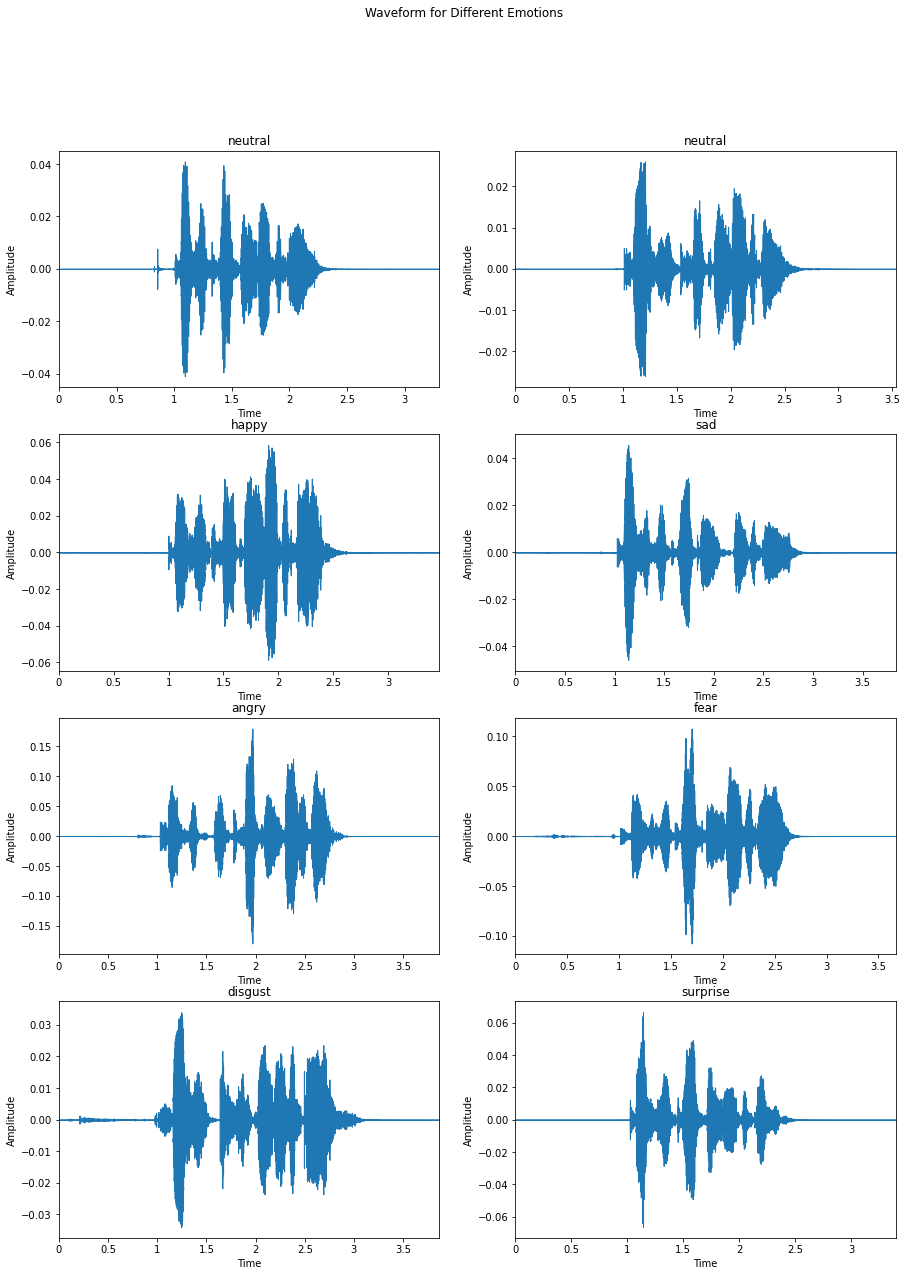

In [62]:
# Pick all the emotions
all_emotions=['neutral','neutral','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
data = []
sampling_rate = []
file_name=[]
ax = {}

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))

fig.suptitle('Waveform for Different Emotions')
k=0
for i in range (4):
    for j in range (2):
        #print(RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01.wav')
        fr=RAV + 'Actor_01/03-01-0'+str(k+1)+'-01-01-01-01.wav'
        da, sr = librosa.load(fr)
        data.append(da)
        sampling_rate.append(sr)
        file_name.append(fr)
        ax[i][j].set_title(all_emotions[k])
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
        k=k+1;

In [63]:
# 0:'neutral', 1:'neutral', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'
ipd.Audio(file_name[7])

### Speech Emotion Compared by Gender

../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-04-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-02.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-08-01-01-01.wav
../datasets/RAVDESS/audio_speech_actors_01-24/Actor_01/03-01-08-01-01-02.wav


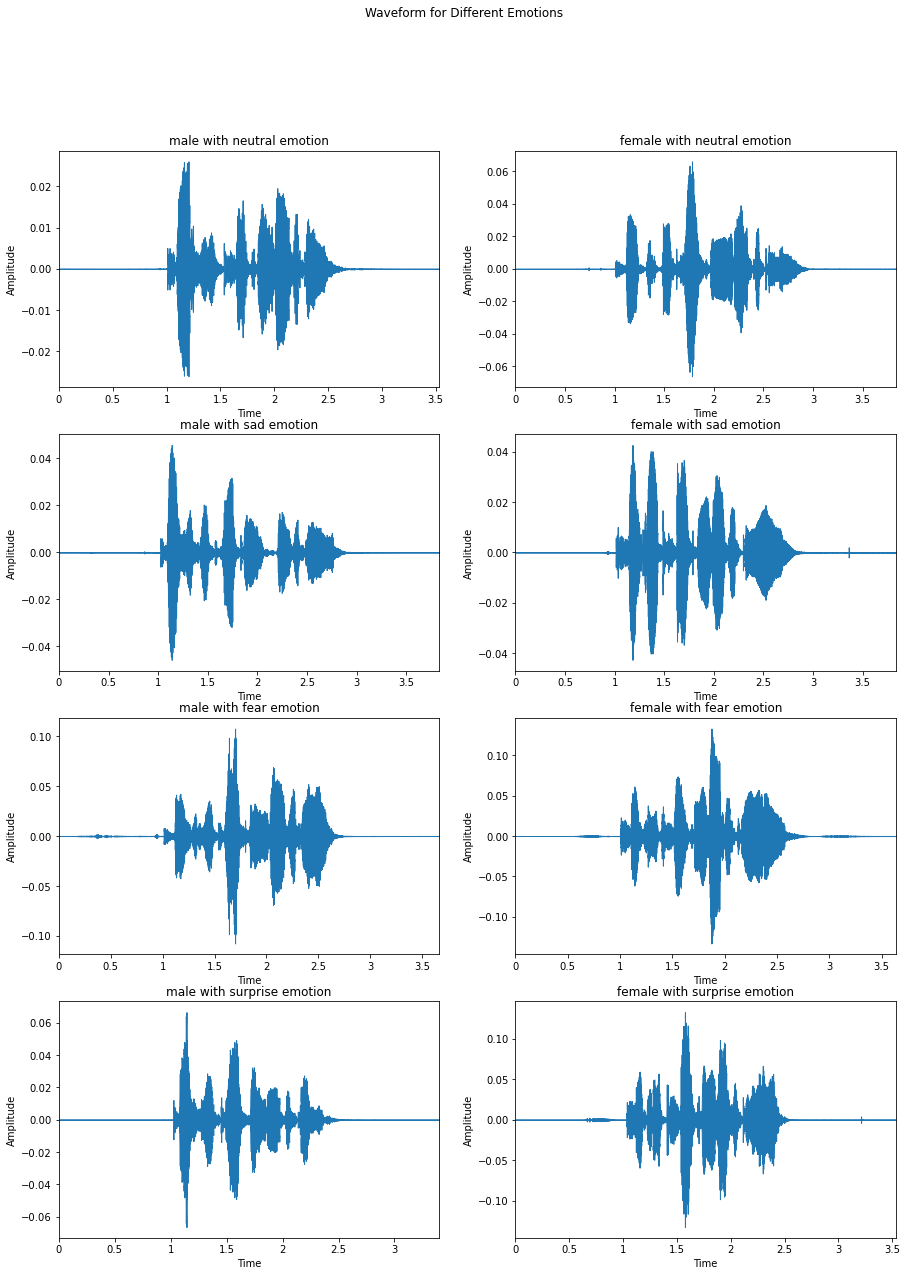

In [64]:
# Pick selected the emotions
selected_emotions=['neutral', 'sad',  'fear', 'surprise']

fig, (ax) = plt.subplots(4, 2,figsize=(15,20))
file_name_by_gender=[]
fig.suptitle('Waveform for Different Emotions')
k=2
m=0
for i in range (4):
    for j in range (2):
        
        if(j==0):
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01.wav')
            fr=RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-01-01.wav'
            gender="male"
        else :
            print(RAV + 'Actor_01/03-01-0'+str(k)+'-01-01-02.wav')
            fr=RAV + 'Actor_02/03-01-0'+str(k)+'-01-01-01-02.wav' 
            gender="female"
        da, sr = librosa.load(fr)
        file_name_by_gender.append(fr)
        ax[i][j].set_title(gender+" with "+ selected_emotions[m]+" emotion")
        ax[i][j].set_ylabel('Amplitude')
        librosa.display.waveplot(da, sr=sr,ax=ax[i][j])
    k=k+2
    m=m+1

In [65]:
# 0:'male with calm', 1:'female with calm', 2:'male with sad', 3:'female with sad', 4:'male with fear', 5:'female with fear', 
# 6:'male with surprise'7:'female with surprise'
ipd.Audio(file_name_by_gender[7])

### Spectrogram View for Different Emotions

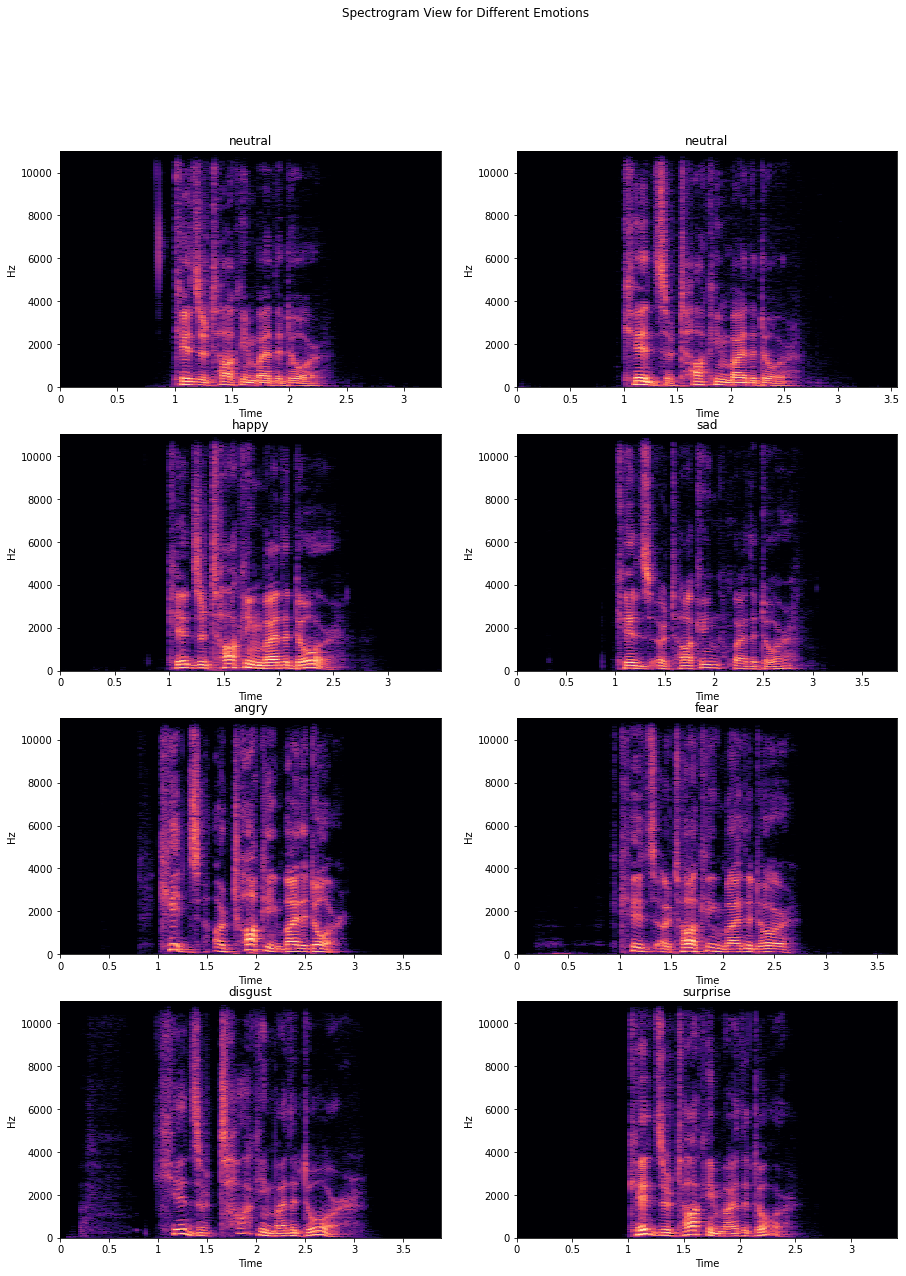

In [66]:
ax1 = {}
all_emotions=['neutral','neutral','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Spectrogram View for Different Emotions')
k=0
for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
#         plt.colorbar()
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',ax=ax1[i][j])
        k=k+1;

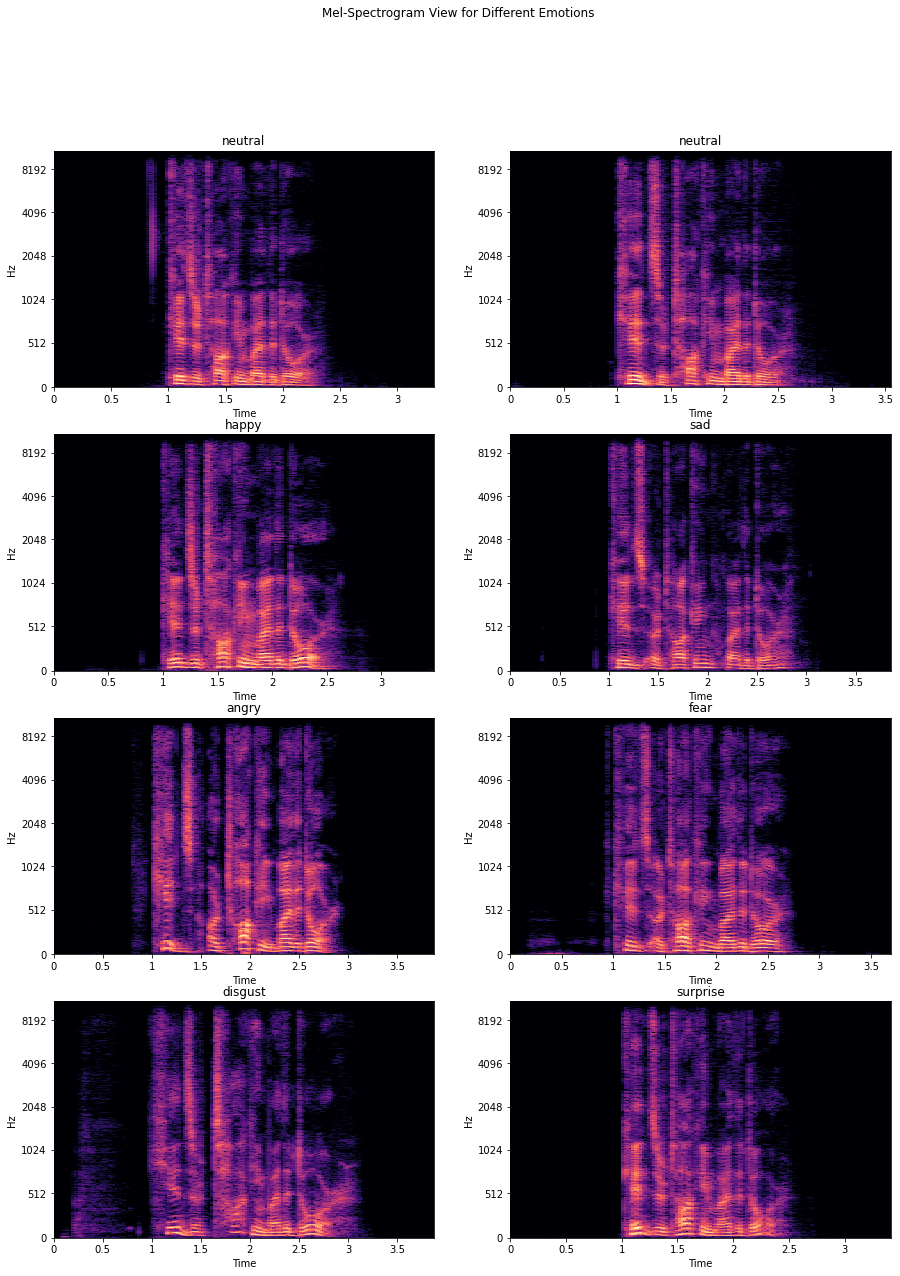

In [67]:
ax1 = {}
all_emotions=['neutral','neutral','happy', 'sad', 'angry', 'fear', 'disgust', 'surprise']
fig, (ax1) = plt.subplots(4, 2,figsize=(15,20))
fig.suptitle('Mel-Spectrogram View for Different Emotions')
k=0

for i in range (4):
    for j in range (2): 
        ax1[i][j].set_title(all_emotions[k])
        Xdb = librosa.amplitude_to_db(abs(librosa.stft(data[k])))
        librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='mel',ax=ax1[i][j])
        k=k+1;

Feature Extraction

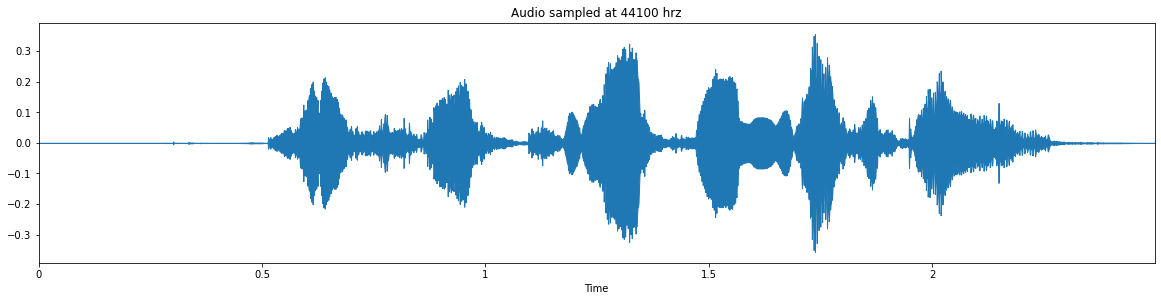

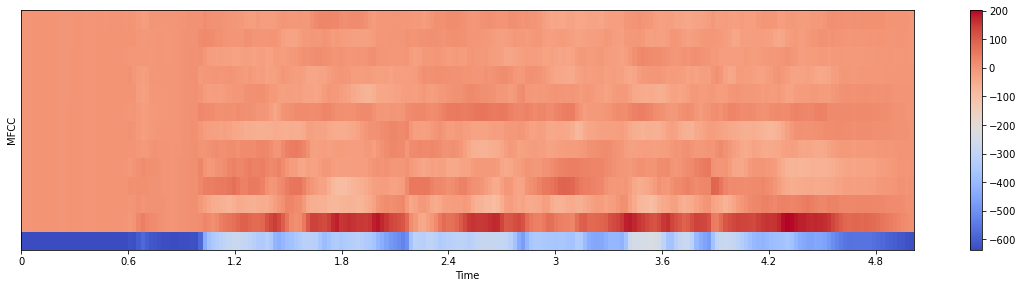

In [68]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

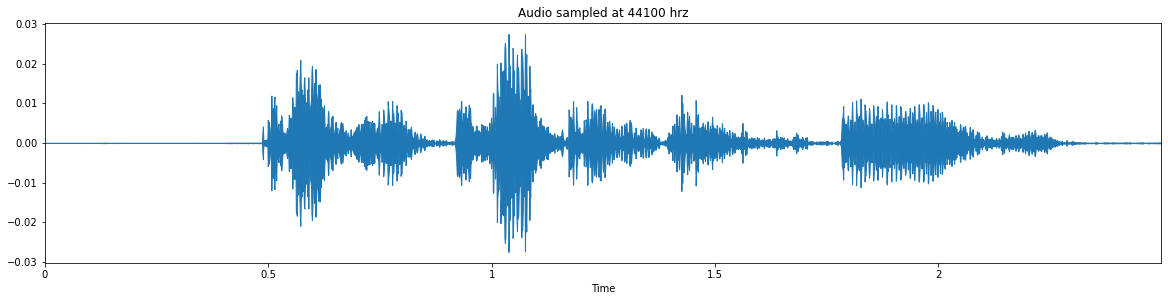

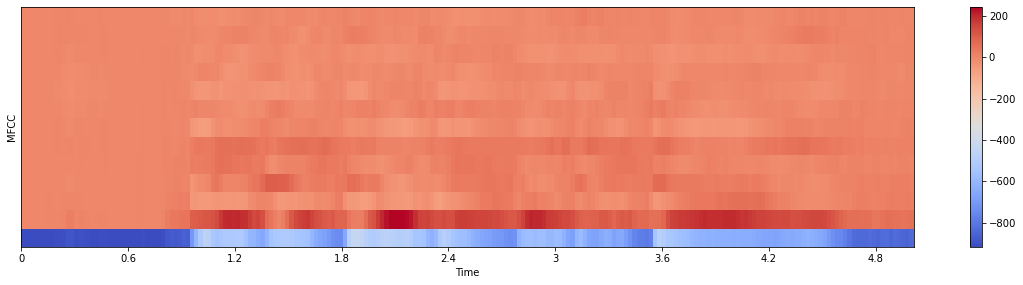

In [69]:
# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

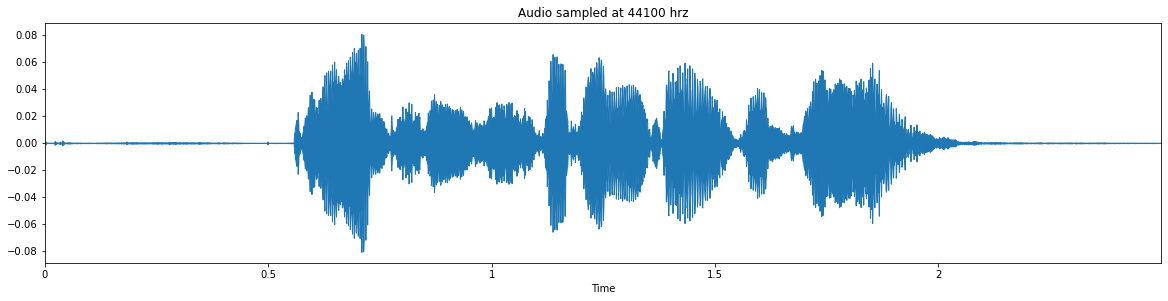

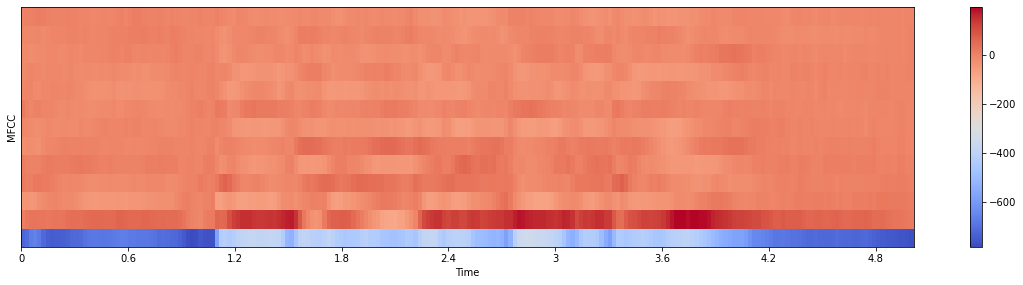

In [70]:
# Source - RAVDESS; Gender - Female; Emotion - Happy 
path = "../datasets/RAVDESS/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

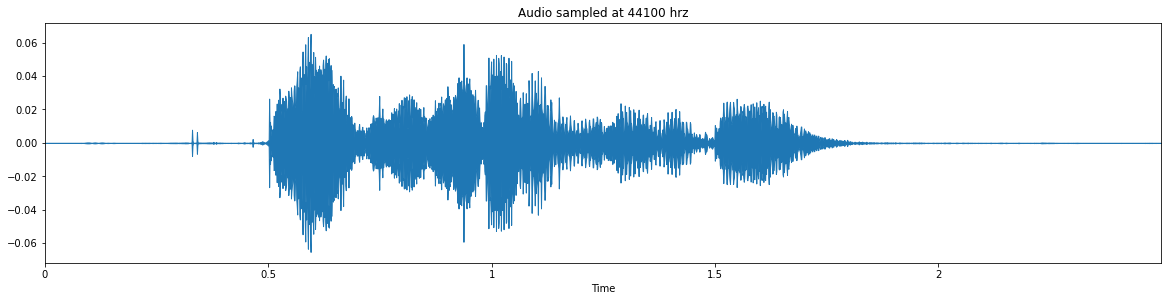

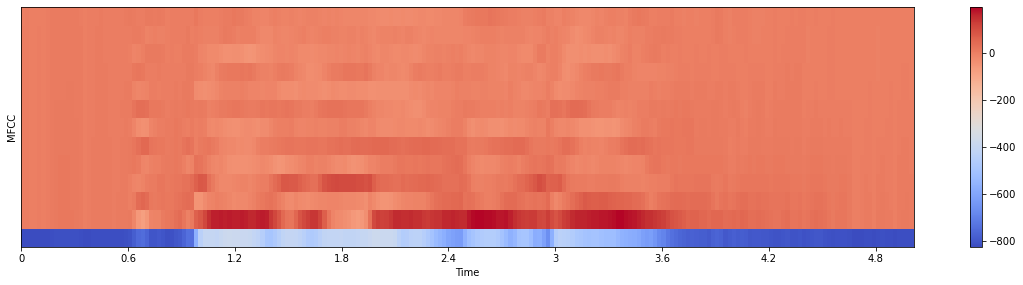

In [71]:
# Source - RAVDESS; Gender - Male; Emotion - Happy 
path = "../datasets/RAVDESS/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.waveplot(X, sr=sample_rate)
plt.title('Audio sampled at 44100 hrz')

# MFCC
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

In [72]:
#Extract features (mfcc, chroma, mel) from a given sound file(with path)
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    result=np.array([])
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    return result

In [73]:
#Emotions in the RAVDESS dataset, it will not take the neutral into the modeling process
emotions={
  '01':'neutral',
  '02':'neutral',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprise'
}
#Emotions to observe(all emotions except neutral)
observed_emotions=['neutral', 'happy', 'sad','angry','fear', 'disgust','surprise']

In [74]:
#Load the data and extract features for each sound file
def load_data(test_size=0.2): 
    x,y=[],[]
    
    # feature to extract
    mfcc = True 
    path= RAV+"Actor_*/*.wav"   
    for file in glob.glob(path):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]] #to get emotion according to filename. dictionary emotions is defined above.
        if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
            continue
        feature=extract_feature(file, mfcc)
        x.append(feature)
        y.append(emotion)
    return {"X":x,"y":y}

In [75]:
#load data into memory
Trial_dict = load_data(test_size = 0.3)

In [76]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])
X.shape, y.shape

((1440, 40), (1440, 1))

In [77]:
#renaming the label column to emotion, store the attributes and label into dataframe
y=y.rename(columns= {0: 'emotion'})
data = pd.concat([X, y], axis =1)
#view the first 10 record
data.head(10)

0          1         2          3         4         5         6  \
0 -700.398926  58.630211 -3.025852  16.040241  4.248529  3.869935 -6.381716   
1 -695.557861  59.240154 -5.372777  19.776365  5.200387  3.324630 -4.668406   
2 -694.004333  61.496510 -3.262743  16.971298  2.142968  4.266798 -5.015399   
3 -687.513367  59.441540 -0.703714  16.645708  3.730826  6.181194 -4.576474   
4 -729.980164  66.515892 -0.941984  19.070974  4.297080  5.635082 -6.752989   
5 -710.053589  70.618843 -1.556971  14.907610  6.146932  4.515686 -7.683697   
6 -700.310669  69.606895 -3.506135  17.969084  1.762492  6.918274 -5.160399   
7 -701.648193  73.041389 -3.148731  17.865999  4.322560  5.934957 -4.265156   
8 -737.635132  75.560745 -0.719248  18.717579  4.626381  6.345685 -7.913329   
9 -701.305725  72.316086 -5.354832  16.675138  2.270264  5.004624 -8.745190   

          7          8         9  ...        31        32        33        34  \
0 -0.188635 -13.735003 -0.319724  ... -2.769772 -2.042009 -2.522663 -2.507448   
1 -2.193975 -14.508076  1.307903  ... -3.102513 -1.697880 -2.922661 -2.544465   
2 -2.617860 -12.885774 -1.302280  ... -2.590943 -1.929074 -2.390322 -2.269381   
3 -4.167900 -12.985402 -0.837521  ... -2.586190 -2.420421 -3.243219 -2.762588   
4 -0.470559 -12.775137 -2.057870  ... -1.797158 -1.296814 -3.051891 -1.131349   
5 -1.616683 -11.140779 -2.212990  ... -2.973075 -2.723013 -4.105726 -3.067898   
6 -1.186939 -12.009208 -1.483264  ... -2.311951 -1.969841 -3.713224 -3.606847   
7 -2.297860 -11.038410 -1.490940  ... -2.292238 -1.674364 -3.187426 -2.925244   
8  1.132612  -9.967860 -1.058235  ... -3.633809 -3.053499 -2.879167 -4.523717   
9 -2.092109 -11.578034 -1.534801  ... -3.141019 -3.548249 -3.604880 -4.542143   

         35        36        37        38        39  emotion  
0 -2.250499 -0.381507 -2.481059 -2.791023 -2.244865  neutral  
1 -1.289832 -0.797254 -3.586074 -2.706395 -2.812933  neutral  
2 -2.486079 -0.589257 -3.248326 -2.979813 -2.769281  neutral  
3 -1.960003 -0.453890 -2.976706 -2.914763 -3.909605  neutral  
4 -1.063672 -1.141021 -2.373389 -3.204345 -3.363193  neutral  
5 -1.945277 -1.405727 -3.772603 -3.569510 -4.787323  neutral  
6 -2.651424 -1.539352 -2.945964 -4.121965 -3.510513  neutral  
7 -2.374242 -0.633166 -2.946774 -2.913152 -3.923706  neutral  
8 -0.313282 -2.087159 -3.237412 -4.037536 -4.003767  neutral  
9 -1.873123 -1.388900 -2.991815 -3.720481 -4.148329  neutral  

[10 rows x 41 columns]

In [78]:
data[10]

0       -1.475747
1       -1.574360
2       -1.563737
3       -0.999946
4       -1.512891
          ...    
1435   -11.572543
1436   -12.340961
1437    -9.864275
1438    -9.872437
1439   -11.226026
Name: 10, Length: 1440, dtype: float64

In [79]:
data['emotion'].value_counts()

neutral     288
surprise    192
fear        192
angry       192
happy       192
disgust     192
sad         192
Name: emotion, dtype: int64

<AxesSubplot:xlabel='emotion', ylabel='1'>

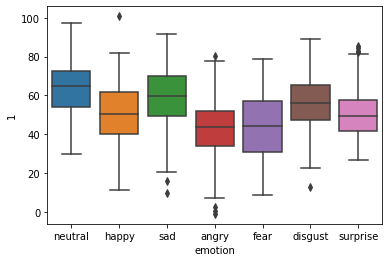

In [80]:
sns.boxplot(x='emotion',y=1, data=data)

Statistical features

MFCC bands on the y-axis and time on the x-axis,

216
216


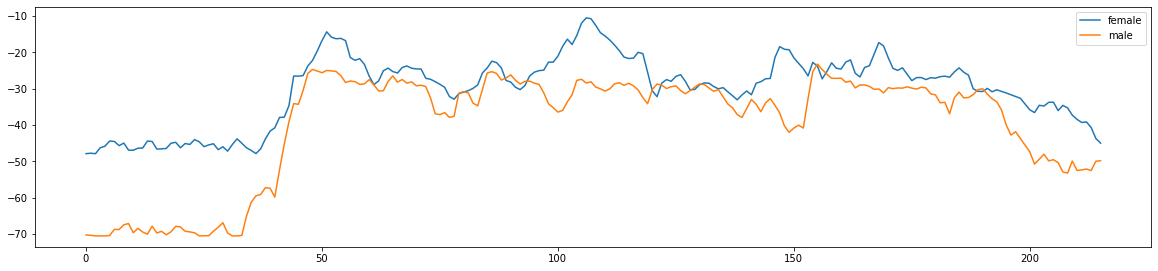

In [81]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = "../datasets/RAVDESS/Actor_09/03-01-05-01-01-01-09.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


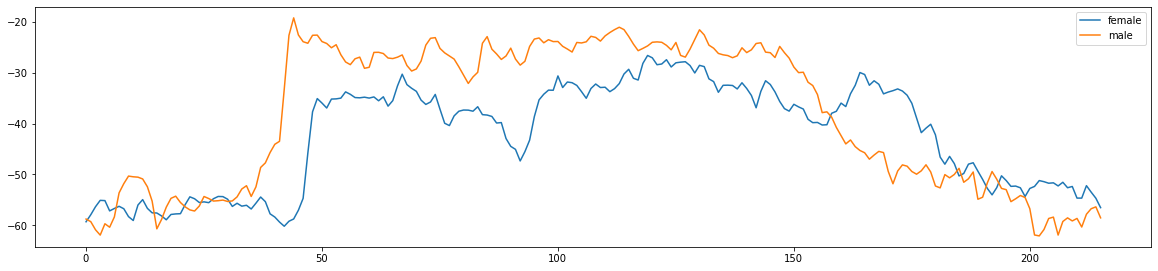

In [82]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = "../datasets/RAVDESS/Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = "../datasets/RAVDESS/Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()